Link to website: https://danellsworth.github.io/

# Financial Sentiment Analysis 

Dan Ellsworth and Alden Pratt

>For our Final Tutorial Project, we will be examining the effectiveness of using sentiment analysis as an indicator of stock price movement. Fluctuations in stock prices can often be attributed to changes in the attitude of its buyers and sellers. Platforms, such as Twitter, where people freely voice their attitude toward companies, can influence traders' decisions. If a particular authority voices optimism regarding the future of a company’s stock, and enough people are convinced to buy, its stock price will increase to meet demand. Conversely, authority figures voicing pessimism generally results in a price decrease. We will be using company sentiment data from Twitter to see if there is a significant correlation between community sentiment and the change in the stock price. In our investigation of this issue, we will explore the following questions: Does sentiment generally follow stock prices, or do stock prices follow sentiment? In other words, should we be looking at sentiment as a leading or lagging indicator? Who is influential on Twitter? Are some companies intrinsically more or less resistant to changes in sentiment? Can our findings be used in developing a complete and profitable trading strategy?

Below are a couple of datasets containing sentiment analysis for various companies:

>https://www.kaggle.com/vivekrathi055/sentiment-analysis-on-financial-tweets 
>https://www.kaggle.com/yash612/stockmarket-sentiment-dataset 

<br>

We will use these datasets in section 3: Broad Market Sentiment Analysis. To determine the effects that Twitter posts have on stock prices, we plan on combining one of these datasets with historical stock price data that can be pulled from Yahoo Finance. Yahoo Finance provides data for stock price fluctuations for every company and every day. We expect that the changes in public sentiment over time will somewhat mirror the changes in the stock price as provided by Yahoo Finance.

## Introduction

### Collaboration Plan 

> We have and will continue to meet via Zoom biweekly, and possibly more frequently as needed to satisfy approaching deadlines. We acknowledge that this will likely change depending on what phase of the project we are in.



### Technologies: 
- Github to coordinate code
- Shared Google Docs for write ups
- Twitter API
- RapidAPI (For Yahoo Finance data)


### Setup up and import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import datetime
import itertools
import yfinance as yf
import quandl
import re
%matplotlib inline
from matplotlib import style

C:\Users\Danel\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


### Machine Learning and NLP imports  

In [2]:
# nltk
import nltk 
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.corpus import stopwords

# sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
#from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

# yellowbrick
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.model_selection import LearningCurve
from yellowbrick.classifier import ROCAUC
from yellowbrick.style.palettes import PALETTES, SEQUENCES, color_palette
from yellowbrick.style import rcmod
rcmod.set_aesthetic(palette='yellowbrick', font='sans-serif', font_scale=1, color_codes=True, rc=None)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Danel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Danel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\Danel\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## 1.  Apple Sentiment Analysis

### Extracting Data

In [3]:
# read in apple sentiment training data
AppleDF = pd.read_csv('Apple-Tweet-Sentiment.csv', encoding="ISO-8859-1")

# import scraped airline Twitter data
Unseen_tweets = pd.read_csv('Apple_Scraped_Tweets.csv')

# declare start and end date for financial data
start = datetime.datetime(2020,11,1)
end = datetime.datetime(2020,12,25)

# read AAPL financial data for declared dates
AAPL = web.DataReader('AAPL', 'yahoo', start, end)

# display sentiment DF
AppleDF.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,date,id,query,sentiment_gold,text
0,623495513,True,golden,10,NaN,3,0.6264,Mon Dec 01 19:30:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\nnot_relevant,#AAPL:The 10 best Steve Jobs emails ever...htt...
1,623495514,True,golden,12,NaN,3,0.8129,Mon Dec 01 19:43:51 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...
2,623495515,True,golden,10,NaN,3,1.0000,Mon Dec 01 19:50:28 +0000 2014,5.400000e+17,#AAPL OR @Apple,3,My cat only chews @apple cords. Such an #Apple...
3,623495516,True,golden,17,NaN,3,0.5848,Mon Dec 01 20:26:34 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,I agree with @jimcramer that the #IndividualIn...
4,623495517,False,finalized,3,12/12/2014 12:14,3,0.6474,Mon Dec 01 20:29:33 +0000 2014,5.400000e+17,#AAPL OR @Apple,NaN,Nobody expects the Spanish Inquisition #AAPL


In [4]:
# display aapl financial data
AAPL.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-11-02,110.680000,107.320000,109.110001,108.769997,122866900.0,108.582664
2020-11-03,111.489998,108.730003,109.660004,110.440002,107624400.0,110.249794
2020-11-04,115.589996,112.349998,114.139999,114.949997,138235500.0,114.752022
2020-11-05,119.620003,116.870003,117.949997,119.029999,126387100.0,118.824997
2020-11-06,119.199997,116.129997,118.320000,118.690002,114457900.0,118.690002


### Natural Language Proccessing (NLP)
> In this section we will try to train a model to classify tweets that include '@Apple' into three categories: positive, neutral, and negative. First, we must clean the tweets...

#### Preprocessing the Training and Testing Data
> To increase the effectivness of our NLP learning algorthim, it is important to clean the tweets before using them for analysis. The preprocessing step eliminates the following:
- stopwords (i.e. 'the', 'a', 'and', 'how', etc.)
- tweets with a question marks - questions are not good indicators of sentiment 
- non-letters (including: numbers, emojis, and punctuation) 
- URL links
- accounts refrenced using '@' symbol
- words less than 3 characters
- retweets - we decided not to count the same tweet twice


In [5]:
# create a class that cleans a list of tweets
class PreProcessTweets:
    def __init__(self):
        self._stopwords = set(stopwords.words('english') + list(punctuation) + ['AT_USER', 'URL']) # set stopwords for each instance
    
    def processTrainingTweets(self, list_of_tweets):
        processedTweets = []
        for index, tweet in list_of_tweets.iterrows():
            processedTweets.append((self._process_training_tweet(tweet['text']), tweet['sentiment']) ) # append cleaned tweet to ProcessedTweets list
        return processedTweets
    
    def processTweets(self, list_of_tweets):
        processedTweets = []
        for index, tweet in list_of_tweets.iterrows():
            processedTweets.append((self._process_tweet(tweet['text']), tweet['sentiment']) ) # append cleaned tweet to ProcessedTweets list
        return processedTweets
    
    # function that cleans training tweets - we do not delete RT's in the training data because these datasets do not contain repeat tweets
    def _process_training_tweet(self, tweet):
        tweet = tweet.lower() # convert all letters to lowercase
        tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', tweet) # removes URL's
        tweet = re.sub('@[^\s]+', 'AT_USER', tweet) # removes usernames
        tweet = re.sub(r'[^\w\s]', '', tweet) # removes all non alphanumeric or non whitespace
        tweet = re.sub(r'[\d]', '', tweet) # removes all digits
        tweet = re.sub(r'\b\w{1,2}\b', '', tweet) # removes any word smaller than 3
        tweet = re.sub(r'\s{2,}', ' ', tweet) # eliminates any spaces greater than 1
        tweet = word_tokenize(tweet) # removes repeated characters (i.e. hellllllo to hello)
        tweet_without_sw = [word for word in tweet if word not in self._stopwords]
        filtered_tweet = (" ").join(tweet_without_sw)
        return filtered_tweet

    # function that cleans scraped tweets - we delete RT's and Questions in this set because it is not hand checked for repeats
    def _process_tweet(self, tweet):
        if (re.search(r'[?]', tweet)):  # Questions do not tell us sentiment, let's get rid of them
            return np.nan
        if (re.search(r'RT', tweet)):  # if it is a retweet, delete it (we don't want to count the same tweet many times)
            return np.nan
        tweet = tweet.lower() # convert all letters to lowercase
        tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', tweet) # removes URL's
        tweet = re.sub('@[^\s]+', 'AT_USER', tweet) # removes usernames
        tweet = re.sub(r'[^\w\s]', '', tweet) # removes all non alphanumeric or non whitespace
        tweet = re.sub(r'[\d]', '', tweet) # removes all digits
        tweet = re.sub(r'\b\w{1,2}\b', '', tweet) # removes any word smaller than 3
        tweet = re.sub(r'\s{2,}', ' ', tweet) # eliminates any spaces greater than 1
        tweet = word_tokenize(tweet) # removes repeated characters (i.e. hellllllo to hello)
        tweet_without_sw = [word for word in tweet if word not in self._stopwords]
        filtered_tweet = (" ").join(tweet_without_sw)
        return filtered_tweet

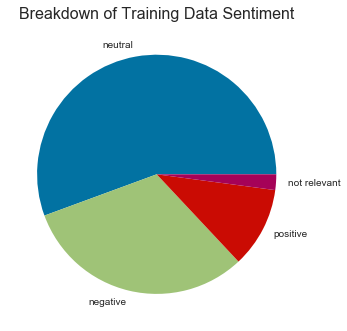

In [6]:
# Print pie chart of sentiment contained in Training data
plt.pie(AppleDF.sentiment.value_counts(), labels = ['neutral','negative','positive', 'not relevant']) #, colors = {"3": "grey", "1": "Red", "5": "g"})
plt.title('Breakdown of Training Data Sentiment', size = 16)
plt.show();

# omit the instances where the tweet is not relevant
AppleDF = AppleDF[AppleDF.sentiment != 'not_relevant']

# grab the columns we care about for training
applelist = AppleDF[['text', 'sentiment']]

tweetProcessor = PreProcessTweets()
preprocessedTrainingSet = tweetProcessor.processTrainingTweets(applelist) # preprocess training data

# revert back to DF
Processed_Tweet_Training = pd.DataFrame((preprocessedTrainingSet), columns =['tweet', 'sentiment'])

Processed_Tweet_Training.dropna(inplace = True) # drop any NA values (tweets that had question marks)

### Text Analysis For Training Data
>We can distingish the types of words that are most frequently used in positive, negative, and neutral tweets. Using the training data, we get the following:

In [7]:
# function that determines the most frequent words contained in pos, neg, and neut tweets
def word_frequency_graph(ProcessedTweetsDF):
    
    positive_text = []
    neutral_text = []
    negative_text = []

    # seperate positive, negative, and neutral tweet text
    for i, row in ProcessedTweetsDF.iterrows():
        if row[1] in ['5', 'positive']:
            positive_text.append(row[0])
        elif row[1] in ['1', 'negative']:
            negative_text.append(row[0])
        else:
            neutral_text.append(row[0])

    # create figure and axes
    fig, axs = plt.subplots(1,3, figsize=(22,17))

    # calculate most frequent positive word tokens
    vectorizer = CountVectorizer()
    doc_pos = vectorizer.fit_transform(positive_text)
    features   = vectorizer.get_feature_names()
    visualizer = FreqDistVisualizer(features=features, orient='h',color = 'g', ax=axs[0])
    visualizer.fit(doc_pos)
    axs[0].set_title('Fequency Distribution of Positive Tweet Tokens')

    # calculate most frequent negative word tokens
    doc_neg = vectorizer.fit_transform(negative_text)
    features   = vectorizer.get_feature_names()
    visualizer = FreqDistVisualizer(features=features, orient='h',color = 'r', ax=axs[1])
    visualizer.fit(doc_neg)
    axs[1].set_title('Fequency Distribution of Negative Tweet Tokens')

    # calculate most frequent neutral word tokens
    vectorizer = CountVectorizer()
    doc_neut = vectorizer.fit_transform(neutral_text)
    features   = vectorizer.get_feature_names()
    visualizer = FreqDistVisualizer(features=features, orient='h',color = 'gray', ax=axs[2])
    visualizer.fit(doc_neut)

    visualizer.show();  # plot figure

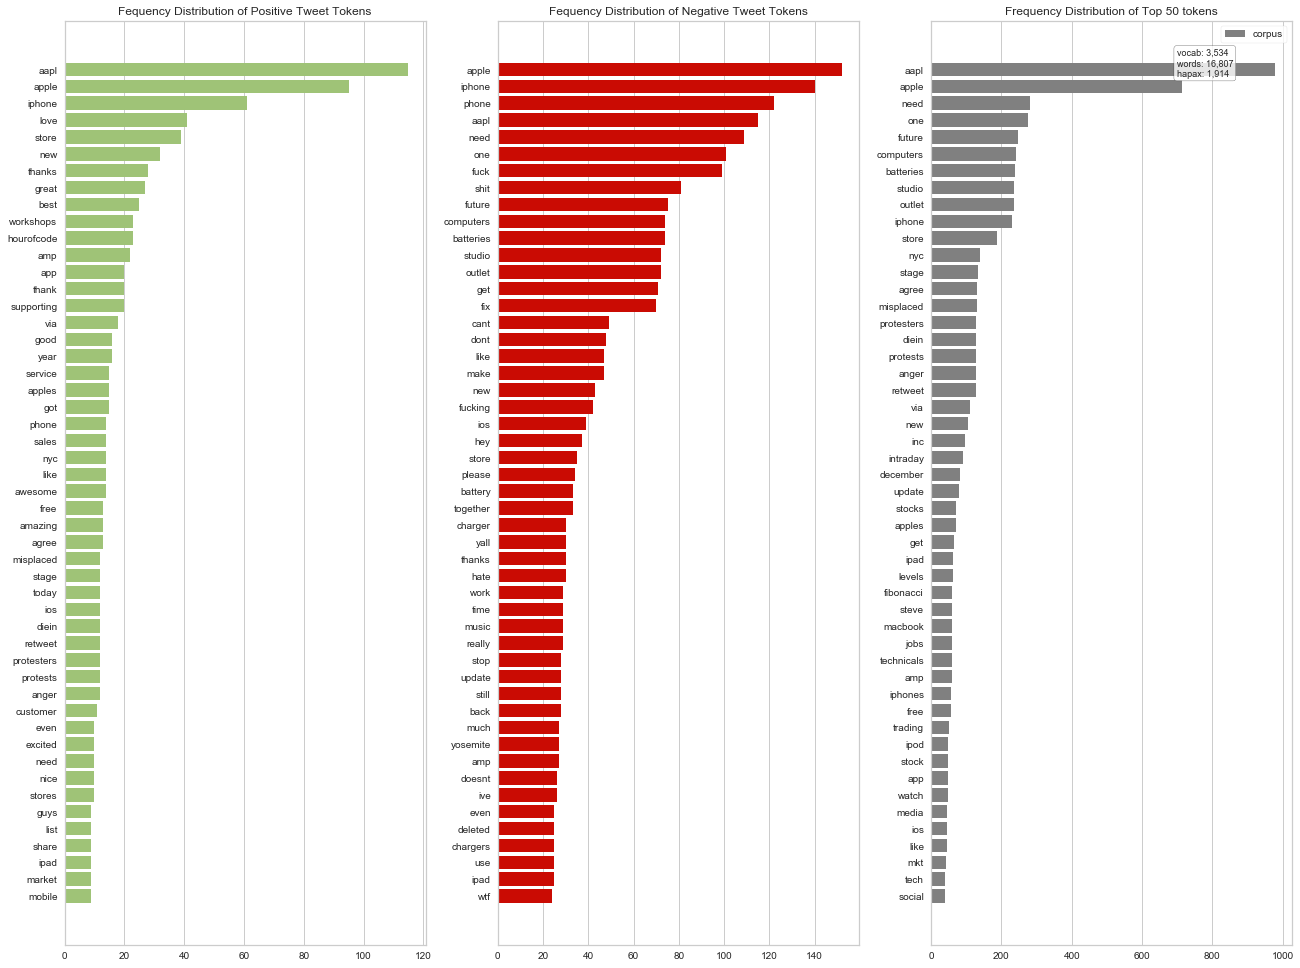

In [8]:
word_frequency_graph(Processed_Tweet_Training)

### Testing the Accuracy of the Model

#### ROCAUC Curves

We can use a ROC-AUC curve for performance measurment. A ROC-AUC (Receiver Operating Characteristic/Area Under the Curve) plot allows us to visualize the tradeoff between the classifier’s sensitivity and specificity.


> ROC (Receiver Operating Characteristic) - shows the performance of classification at all classification thresholds (positive, neutral, and negative). The ROC is a computation of the relationship between true positives and false positives.


>AUC (Area Under the Curve) - represents the degree or measure of separability (i.e. how well is the model at distinguishing the various classes). The higher the AUC, the better the model typically is.

We can see from the graph below that our model is worse at correctly classifiying positive tweets.

In [9]:
def ROC_Curve(Processed_Tweet_Training):  
    # create dummy variables - i.e. tokenize words and label 1 or 0 
    mlb = MultiLabelBinarizer()
    X = pd.DataFrame(mlb.fit_transform([x.split(' ') for x in Processed_Tweet_Training['tweet']]),columns=mlb.classes_)

    # transform sentiment into labels matching tokenized word DF
    y = LabelEncoder().fit_transform(Processed_Tweet_Training['sentiment'])

    # Create the train and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    # create figure and axes
    fig, ax = plt.subplots(figsize=(10,7.5))
    
    # Instaniate the classification model and visualizer
    model = MultinomialNB()
    visualizer = ROCAUC(model, classes=["Negative Sentiment", "Neutral Sentiment", "Positive Sentiment"], ax = ax)
    

    visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
    visualizer.score(X_test, y_test)        # Evaluate the model on the test data
    visualizer.show();               # Finalize and render the figure

C:\Users\Danel\anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


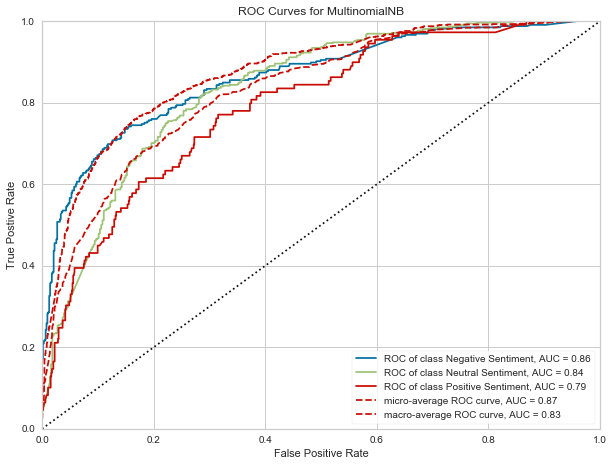

In [10]:
# Call Receiver Operating Characteristic Function
ROC_Curve(Processed_Tweet_Training)

#### Visualizing the Classification Model (F-Score)

To visualize the learning curve of our classification model, we can plot how the f-score changes over many training iterations. We choose to use the MultinomialNB (Multinomial Naive Bayes) classifier because we did not have that much training data (roughly 4,000 tweets), and NB models train faster than other models. In the future, we are curious to compare this model with a Ridge Regression classifier (RidgeClassifier). 

>This learning curve shows the relationship of the training score vs. the cross-validated test score for an estimator with a varying number of training samples. The curves are plotted with the mean scores, but variability during cross-validation is shown with the shaded areas that represent a standard deviation above and below the mean for all cross-validations. This visualization can indicate two things:

>1. How much the estimator benefits from more data (e.g. do we have enough data).

>2. If the estimator is more sensitive to error due to variance vs. error due to bias (bias-variance tradeoff).

We can see that the training and test scores have not yet converged, so our model would likely benefit from more training data. Our model suffers primarily from error due to variance (the CV scores for the test data are more variable than for training data), so the model may be overfitting the data.

In [11]:
def Visualize_Classification_Model(Processed_Tweet_Training):   
    
    mlb = MultiLabelBinarizer()
    X = pd.DataFrame(mlb.fit_transform([x.split(' ') for x in Processed_Tweet_Training['tweet']]),columns=mlb.classes_)

    # transform sentiment into labels matching tokenized word DF
    y = LabelEncoder().fit_transform(Processed_Tweet_Training['sentiment'])
    
    # Create the learning curve visualizer
    cv = StratifiedKFold(n_splits=12)
    sizes = np.linspace(0.3, 1.0, 10)
    
     # create figure and axes
    fig, ax = plt.subplots(figsize=(10,7.5))
    
    # Instantiate the classification model and visualizer
    model = MultinomialNB()
    visualizer = LearningCurve(
        model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4, ax = ax
    )

    visualizer.fit(X, y)        # Fit the data to the visualizer
    visualizer.show();           # Finalize and render the figure

C:\Users\Danel\anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


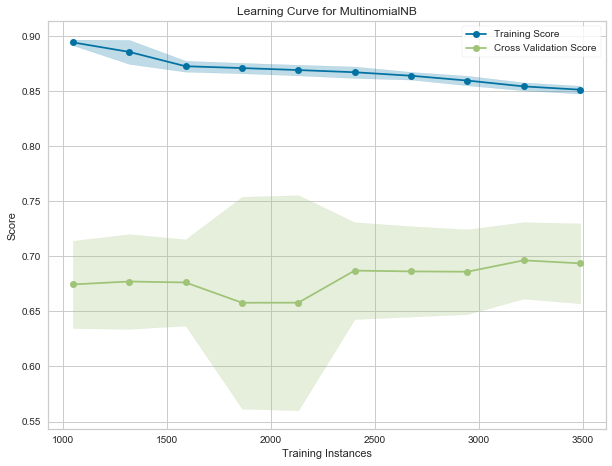

In [12]:
# create visualization of model - this might take a min to run
Visualize_Classification_Model(Processed_Tweet_Training)

#### Classification Report

We can also measure the Precision, Recall, and F1-Score. These metrics are important because we know our dataset is imbalanced (there is not an equal number of positive and negative tweets). We do the following calculations: 

<br>

>$$ \text {Precision} = \frac{\text{Number of true positive cases}}{\text{(Number of all the positive cases}} $$

 <br>
 
>$$ \text {Recall} = \frac{\text{Number of true positives}}{\text{(# of true positives + # of false negatives}} $$

<br>

>$$ F1 = \frac{\text{(Precision * Recall) * 2}}{\text{Precision + Recall}} $$

In [13]:
X = Processed_Tweet_Training['tweet'] 
y = Processed_Tweet_Training["sentiment"]

# split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=41)

# vectorize using ngram 2
cnt = CountVectorizer(analyzer = 'char',ngram_range=(6,6))

# specify the model
pipeline = Pipeline([
   ('vectorizer',cnt),  
   ('model',MultinomialNB())
])

# fit the pipeline and calculate predictions on the test set
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)

confusion_matrix(y_test, y_pred)

# print classification report - where 1 is negative, 3 is neutral, and 5 positive
print(classification_report(y_test,y_pred)) 

              precision    recall  f1-score   support

           1       0.66      0.73      0.69       413
           3       0.80      0.77      0.79       716
           5       0.49      0.43      0.46       127

    accuracy                           0.72      1256
   macro avg       0.65      0.64      0.64      1256
weighted avg       0.72      0.72      0.72      1256



In [14]:
# training on the entire dataset

# vectorize using ngram 6
cnt = CountVectorizer(analyzer = 'char',ngram_range=(6,6))

# specify the model
pipeline = Pipeline([
   ('vectorizer',cnt),  
   ('model',MultinomialNB())
])

# fit the pipeline and calculate predictions on the test set
pipeline.fit(X,y)
y_pred = pipeline.predict(X_test)

### Predicting Classification of Unseen Data

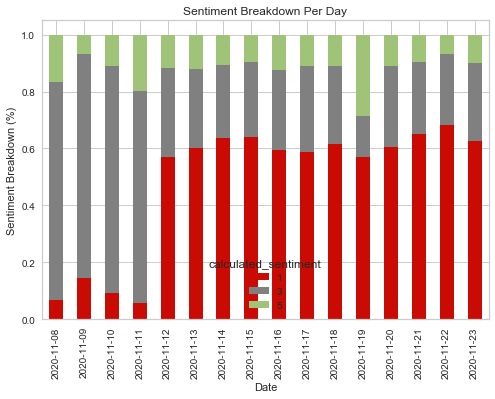

In [15]:
# format data for preprocessing 
Unseen_tweets_text = Unseen_tweets[['text', 'sentiment']]

Preprocessed_Data = tweetProcessor.processTweets(Unseen_tweets_text) # preprocess test data
Processed_Tweets = pd.DataFrame((Preprocessed_Data), columns =['tweet', 'sentiment'])

Apple_Data = Unseen_tweets[Processed_Tweets['tweet'].notnull()] # get rid of omited rows in original DF
Apple_Data.reset_index(inplace = True) # permanently reset the index to account for dropped values

Processed_Tweets.dropna(inplace = True) # drop any NAN rows (tweets with question marks)
y = Processed_Tweets["tweet"] 

y_pred = pipeline.predict(y) # predict y labels

# make dataframe that includes the tweets and predicted labels
Results = pd.DataFrame(list(zip(Processed_Tweets.tweet, y_pred)),
  columns=['tweet','calculated_sentiment'])

# inner join the two DF's on the index column - which coresponds to the same observation
AppleResultsDF = Results.merge(Apple_Data, how='inner', left_index = True, right_index = True)

# change date column to datetime object
AppleResultsDF['date'] = pd.to_datetime(AppleResultsDF['date'])

# plot sentiment given day in a stacked bar graph
sentiment_day_counts = pd.crosstab(AppleResultsDF['date'].dt.date, AppleResultsDF.calculated_sentiment)
(sentiment_day_counts.divide(
    sentiment_day_counts.sum(axis=1), axis=0)
).plot.bar(stacked=True, color = ['r', 'grey', 'g'])
plt.title('Sentiment Breakdown Per Day')
plt.ylabel('Sentiment Breakdown (%)')
plt.xlabel('Date')
plt.show();

### Text Analysis for Predicted Labels

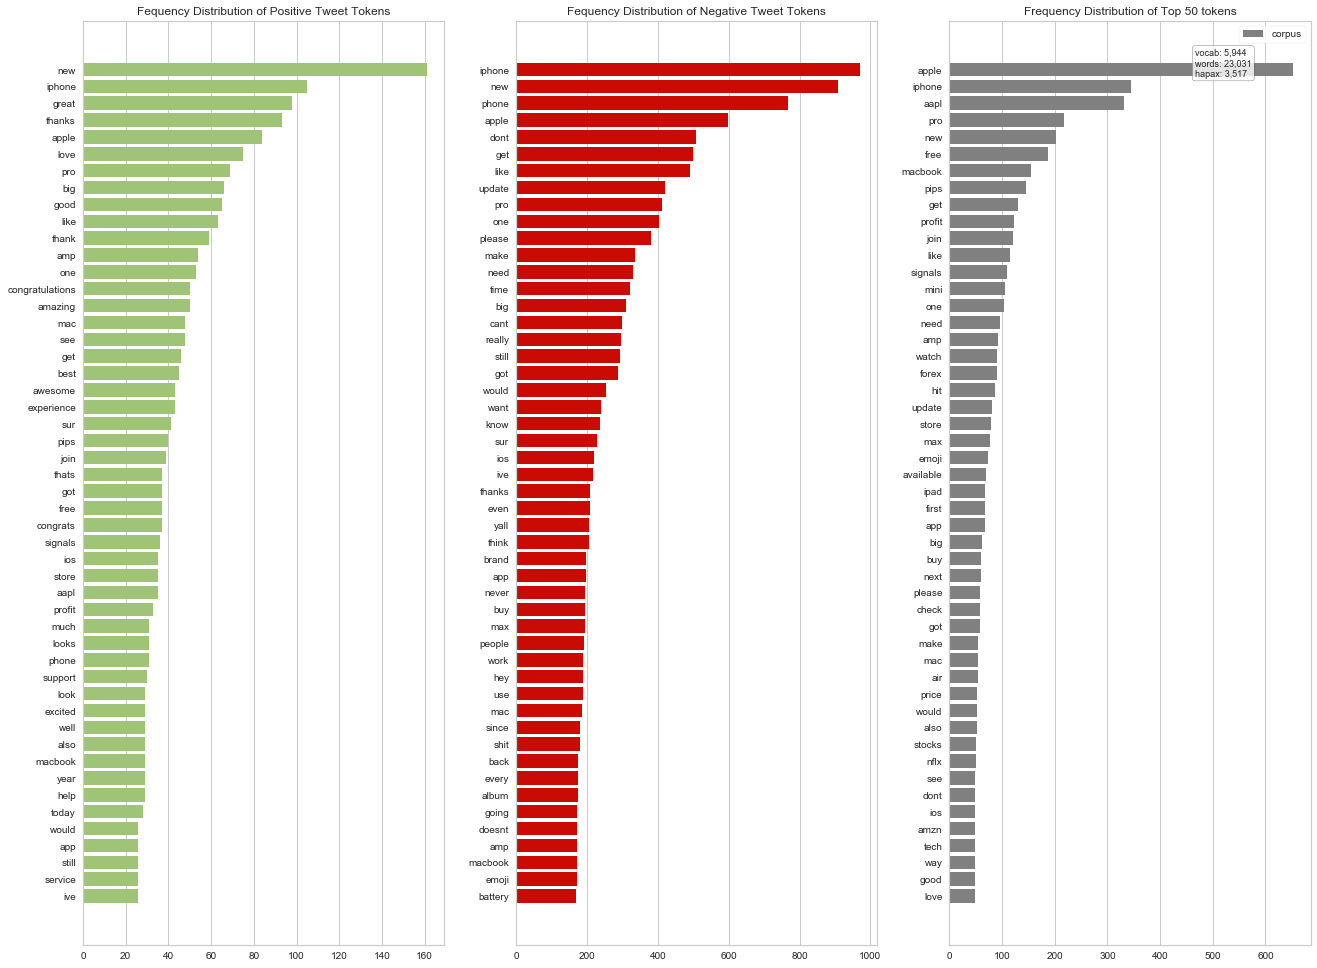

In [16]:
# Word Frequency analysis on the predicted labels
word_frequency_graph(AppleResultsDF[['tweet','calculated_sentiment']])

### Apple Twitter Sentiment vs. Stock Price

#### Calculating Changes in Sentiment
> Here we plot out the change in sentiment each day to gauge trends over time. Ideally, we would have more data so that we could take the rolling average of the calculated sentiment scores (this would reduce the noise we see here). The first graph uses the average sentiment score per day (between \[-1, 1\]), and the second graph displays the average sentiment's daily percent change.

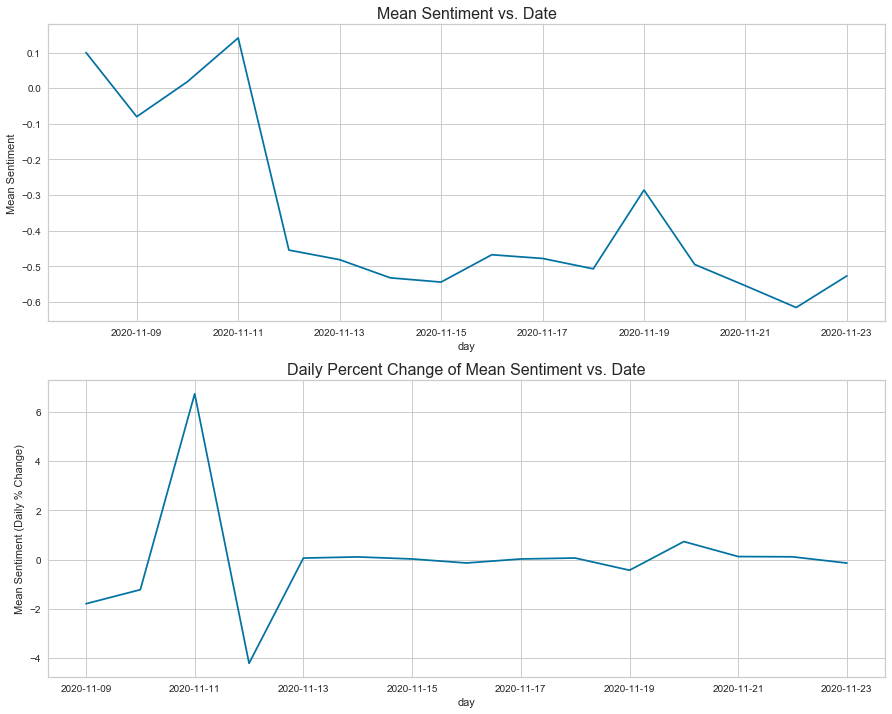

In [17]:
# map the strings indicating positive, negative, and neutral to numeric values 1, -1, and 0 respectively
AppleResultsDF['calculated_sentiment'] = AppleResultsDF["calculated_sentiment"].map({
    "5": 1,
    "3": 0,
    "1": -1
})

# convert 'date' to datetime object
AppleResultsDF['date'] = pd.to_datetime(AppleResultsDF['date'])
AppleResultsDF['day'] = AppleResultsDF["date"].dt.date # create column for date, excluding time (i.e. 11/22/2020)

# Create two new Df's to plot
Mean = AppleResultsDF.groupby(['day']).calculated_sentiment.mean() # mean sentiment analysis score by day
Pct_Change = AppleResultsDF.groupby(['day']).calculated_sentiment.mean().pct_change(1) # daily pct change of mean sentiment


# matplotlib operations
fig, ax = plt.subplots(2,1,figsize=(15,12))
ax[0].set_title('Mean Sentiment vs. Date',size = 16)
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Mean Sentiment')
Mean.plot(ax=ax[0]);

ax[1].set_title('Daily Percent Change of Mean Sentiment vs. Date',size = 16)
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Mean Sentiment (Daily % Change)')
Pct_Change.plot(ax=ax[1]);

#### Apple's Stock Price Over the Same Period
> To see how Apple's stock has reacted over the same period, we calculate daily returns and cumulative returns. We use the 5-day rolling average of each to eliminate some of the market noise. Since both of these graphs are represented by percentages, we can conveniently relate Apple's price performance to the sentiment graph represented above. 

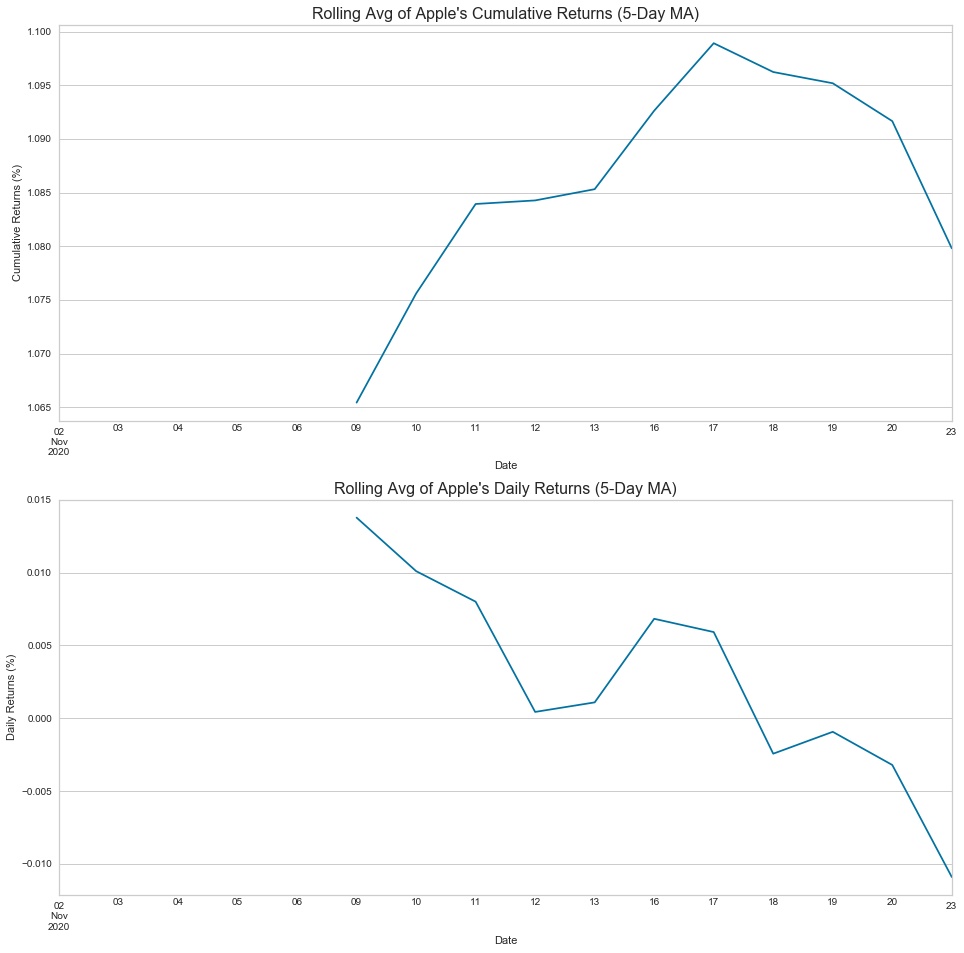

In [18]:
# calculate daily pct returns
AAPL['returns'] = AAPL['Close'].pct_change(1)

# calculate the cumulative returns
AAPL['Cumulative Return'] = (1 + AAPL['returns']).cumprod()

# create figure and axes
fig, ax = plt.subplots(2,1,figsize=(16,16))

# plot the 5-day rolling avg of aapl's cumulative returns
AAPL['Cumulative Return'].rolling(5).mean().plot(label='Apple', ax = ax[0])

# plot the 5-day rolling avg of aapl's daily returns
AAPL['returns'].rolling(5).mean().plot(label= 'Apple', ax = ax[1])


ax[0].set_title('Rolling Avg of Apple\'s Cumulative Returns (5-Day MA)', size = 16)
ax[0].set_ylabel('Cumulative Returns (%)')

ax[1].set_title('Rolling Avg of Apple\'s Daily Returns (5-Day MA)', size = 16)
ax[1].set_ylabel('Daily Returns (%)')

plt.show();

### Preliminary Thoughts
> While the NLP classification appears to be relatively accurate, we need to address some bias in the training dataset. With such a limited dataset, it is impossible to draw any meaningful conclusions in regards to where Apple stock might be headed. It is clear, that more people are heading to Twitter to complain about an Apple product than praise it; however, this does not have much (if any) significance relating to Apple's stock. We can consider a few things:
-  People have an incentive to complain when a product malfunctions but there is little incentive to praise a product when it works how we expect it to (Many negatively classified tweets reference the Big Sur update - we expect an update to work, but when it doesn't, an angry tweetstorm ensues)
- Apple has an ecosystem that makes it difficult for customers to move away from these devices after one bad experience (negative sentiment does not necessarily mean Apple is losing customers).

## 2. Gauging Airline Sentiment Using NLP
Let's try this with a variety of airline tweets. Again, we will see more people tweet about a negative flight expirences than good ones, but would we rather own the airline with the fewest or most complaints? It might make a difference over the long-term.

### Extracting Airline Data

In [19]:
# import testing data
Training_tweets = pd.read_csv('Twitter_Airline_Sentiment_Labeled.csv')

# rename the 'airline_sentiment' column to 'sentiment'
Training_tweets.rename(columns = {'airline_sentiment': 'sentiment'}, inplace = True)

# filter dataframe to only include 'text' and 'sentiment' columns
Train_tweets_text = Training_tweets[['text', 'sentiment']]

# declare start and end date for financial data
start = datetime.datetime(2020,11,1)
end = datetime.datetime(2020,12,25)

# read data for airlines of interest
LUV = web.DataReader('LUV', 'yahoo', start, end)
UAL = web.DataReader('UAL', 'yahoo', start, end)
AAL = web.DataReader('AAL', 'yahoo', start, end)
DAL = web.DataReader('DAL', 'yahoo', start, end)

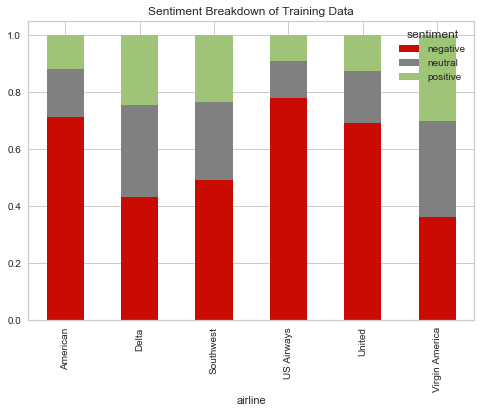

In [20]:
# import testing data
Testing_tweets = pd.read_csv('Twitter_Airline_Sentiment_Labeled.csv')

# print graph of the training set - how each airline breaks down
sentiment_airline_counts = pd.crosstab(Training_tweets['airline'], Training_tweets.sentiment)
(sentiment_airline_counts.divide(
    sentiment_airline_counts.sum(axis=1), axis=0)
).plot.bar(stacked=True, color = ['r', 'grey', 'g'])
plt.title("Sentiment Breakdown of Training Data")
plt.show();


tweetProcessor = PreProcessTweets()
preprocessedTrainingSet = tweetProcessor.processTrainingTweets(Train_tweets_text) # preprocess training data

Processed_Tweet_Training = pd.DataFrame((preprocessedTrainingSet), columns =['tweet', 'sentiment'])
Processed_Tweet_Training.dropna(inplace = True) # drop any NA values (tweets that had question marks)

### Text Analysis of Training Set

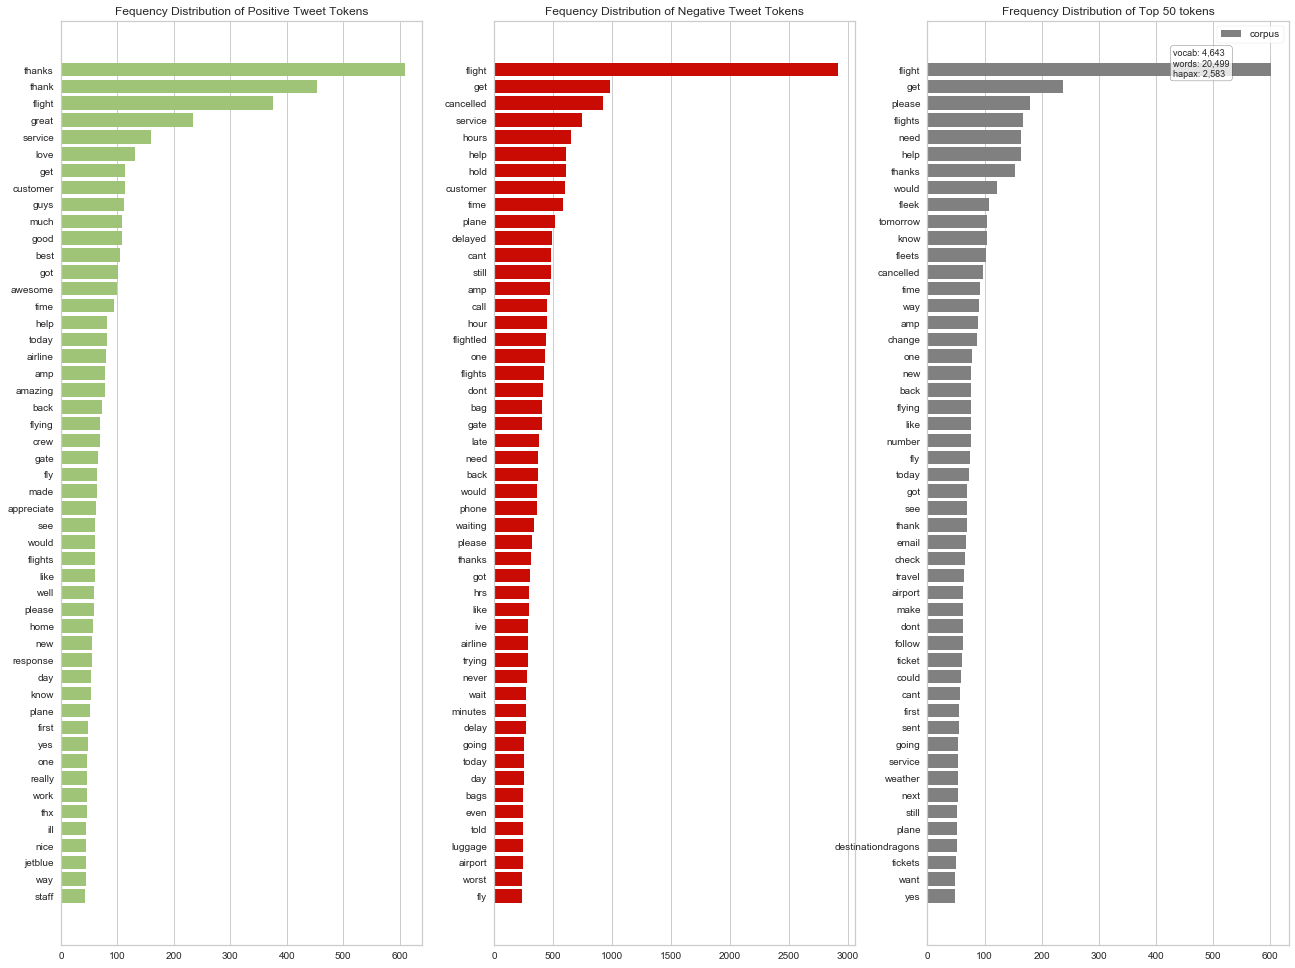

In [21]:
word_frequency_graph(Processed_Tweet_Training)

### Testing the Accuracy

#### ROCAUC Curves
> Our ROC curves indicate this model is better at classifying positive tweets than negative and neutral tweets. Overall, the macro avg AUC of 0.88 is a good indication the model is working.

C:\Users\Danel\anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


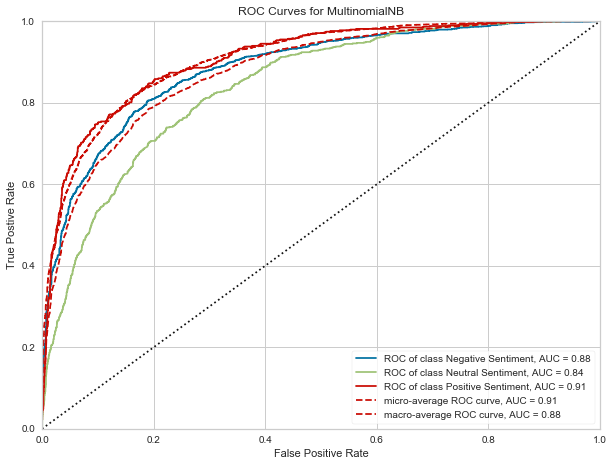

In [22]:
# Call Receiver Operating Characteristic Function
ROC_Curve(Processed_Tweet_Training)

#### Visualizing the Classification Model (F-Score)

>We can see that the training and test scores have not yet converged, but the test data seems to have converged at an F1 score of 0.73. This likely means the model's accuracy would not significantly change with more data.  Finally, our model's bias-tradeoff error is relatively balanced (the CV scores for the test data and training data are equally variable). This model also primarily suffers from error due to variance (the CV scores for the test data are more variable than for training data) so the model may be overfitting the data.


C:\Users\Danel\anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


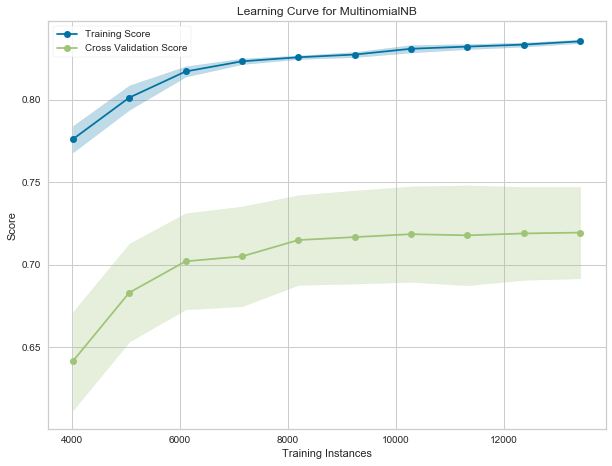

In [23]:
Visualize_Classification_Model(Processed_Tweet_Training)

#### Classification Report

In [24]:
# define X as the tweets and y as the labels 
X = Processed_Tweet_Training['tweet'] 
y = Processed_Tweet_Training["sentiment"]

# split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=41)

# vectorize using ngram 2
cnt = CountVectorizer(analyzer = 'char',ngram_range=(5,5))

# specify the model
pipeline = Pipeline([
   ('vectorizer',cnt),  
   ('model',MultinomialNB())
])

# fit the pipeline and calculate predictions on the test set
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)

# print classification report - determines the accuracy of model
print(classification_report(y_test,y_pred))

# zip the calculated results together with the actual results
Results = pd.DataFrame(list(zip(y_test, y_pred)),
  columns=['actual sentiment','calculated sentiment'])

              precision    recall  f1-score   support

    negative       0.78      0.94      0.85      3021
     neutral       0.68      0.37      0.48      1059
    positive       0.69      0.57      0.62       752

    accuracy                           0.76      4832
   macro avg       0.72      0.63      0.65      4832
weighted avg       0.74      0.76      0.74      4832



In [25]:
# retraining using all the data 
# vectorize using ngram 2
cnt = CountVectorizer(analyzer = 'char',ngram_range=(6,6))

# specify the model
pipeline = Pipeline([
   ('vectorizer',cnt),  
   ('model',MultinomialNB())
])

# fit the pipeline and calculate predictions on the test set
pipeline.fit(X,y);

### Predicting Unseen Data

In [26]:
# import unseen airline tweet data (saved on local storage)
Airline_Data = pd.read_csv('Airline_Scrapped_Tweets.csv')
Airline_Tweets = Airline_Data[['text', 'sentiment']]

tweetProcessor = PreProcessTweets()
Preprocessed_Airline_Tweets = tweetProcessor.processTweets(Airline_Tweets) # preprocess training data

# format the cleaned tweets (proccesed) into a new DF
Processed_Tweets = pd.DataFrame((Preprocessed_Airline_Tweets), columns =['tweet', 'sentiment'])

Airline_Data = Airline_Data[Processed_Tweets['tweet'].notnull()] # get rid of omited rows in original DF
Airline_Data.reset_index(inplace = True) # permanently reset the index to account for dropped values

# drop any Nan rows (tweets with question marks)
Processed_Tweets.dropna(inplace = True)

y = Processed_Tweets["tweet"] # let y equal the tweet column
y_pred = pipeline.predict(y) # predict labels for y

# zip together the predictions and the cleaned tweets to a new DF
Results = pd.DataFrame(list(zip(Processed_Tweets.tweet, y_pred)),
  columns=['tweet','calculated_sentiment'])

# inner join the two DF's on the index column - which coresponds to the same observation
AirlineResultsDF = Results.merge(Airline_Data, how='inner', left_index = True, right_index = True)

### Text Analysis for Predicted Labels
>We now use the same text analysis strategy to gauge the types of words used based on the predicted labels. We get the following chart:

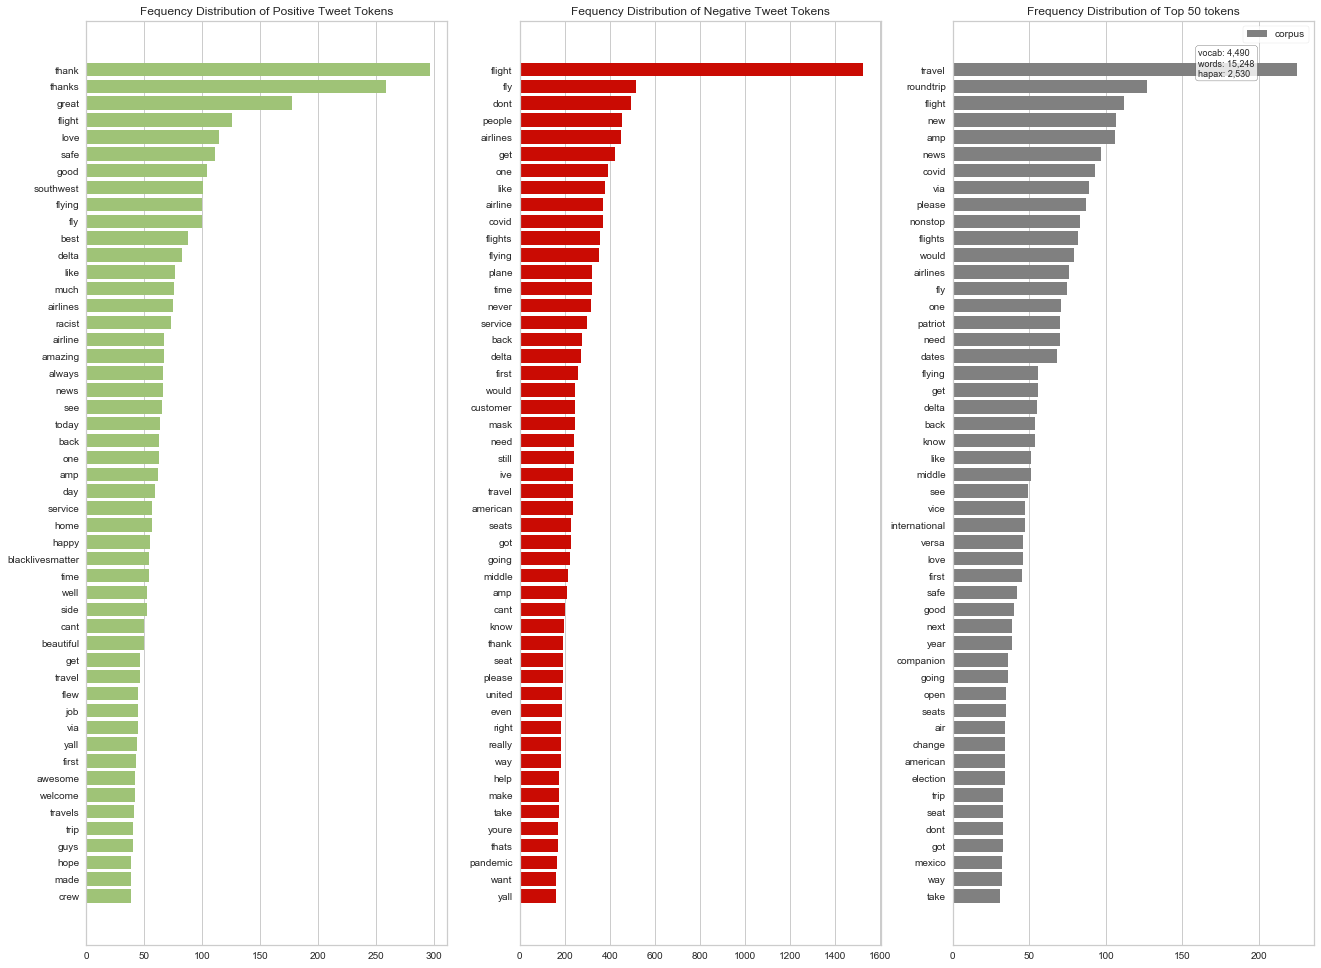

In [27]:
word_frequency_graph(AirlineResultsDF[['tweet','calculated_sentiment']])

### Airline Twitter Sentiment Vs. Stock Prices
> To gauge how Twitter feels about each airline, we take the mean of the predicted sentiment classification. Many of these tweets contain feedback from customers' flight experience. We can see that American Airlines has the worst average sentiment score by a large margin.

In [28]:
# map string labels to numeric scale - pos: 1, neut: 0, neg: -1
AirlineResultsDF['calculated_sentiment'] = AirlineResultsDF["calculated_sentiment"].map({
    "positive": 1,
    "neutral": 0,
    "negative": -1
})

print(AirlineResultsDF.groupby('airline').calculated_sentiment.mean())

airline
American    -0.642950
Delta       -0.491573
Southwest   -0.453936
United      -0.460059
Name: calculated_sentiment, dtype: float64


#### Calculating Changes in Sentiment
> Here we plot out the changes in sentiment each day to gauge trends over time. Ideally, we would have more data so that we could take the rolling average of the calculated sentiment scores (this would reduce the noise we see here). The first graph uses the average sentiment score per day (between \[-1, 1\]), and the second graph displays the average sentiment's daily percent change.

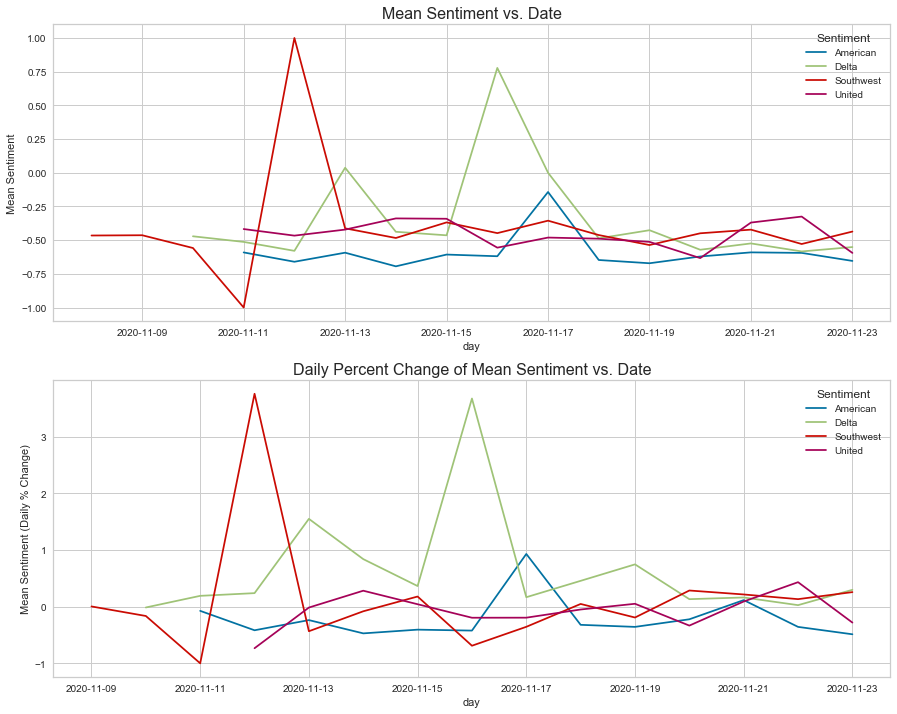

In [29]:
# convert 'date' to datetime object
AirlineResultsDF['date'] = pd.to_datetime(AirlineResultsDF['date'])
AirlineResultsDF['day'] = AirlineResultsDF["date"].dt.date  # create column for date, excluding time (i.e. 11/22/2020)

# calculate the mean sentiment given the airline and day
Mean = AirlineResultsDF.groupby(['day','airline']).calculated_sentiment.mean()

# transform 'calculated_sentiment' so all values are positive (between [0,2])
AirlineResultsDF['calculated_sentiment'] += 1 
Pct_Change = AirlineResultsDF.groupby(['day','airline']).calculated_sentiment.mean().pct_change(1) # find daily pct change

# unstack the `airline` index, to place it as columns
Mean = Mean.unstack(level='airline')
Pct_Change = Pct_Change.unstack(level='airline')

# The name of columns will become the name of legend when using dataframe plot
Mean.columns.name = 'Sentiment'
Pct_Change.columns.name = 'Sentiment'

# Here we use dataframe plot function
fig, ax = plt.subplots(2, 1, figsize=(15,12))
ax[0].set_title('Mean Sentiment vs. Date',size = 16)
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Mean Sentiment')
Mean.plot(ax=ax[0]);

# plot pct change on 2nd axis
ax[1].set_title('Daily Percent Change of Mean Sentiment vs. Date', size = 16)
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Mean Sentiment (Daily % Change)')
Pct_Change.plot(ax=ax[1]);

#### Stock Prices Over the Same Period
> To see how stocks reacted over the same period, we calculate daily returns and cumulative returns for each airline. Since we have access to more financial data, we take the 5-day rolling avg of each of these calculations (to eliminate some of the market noise). Note that both of these graphs are represented by percentages; therefore, we can conveniently compare each company and relate stock price movement to the sentiment graph represented above. 

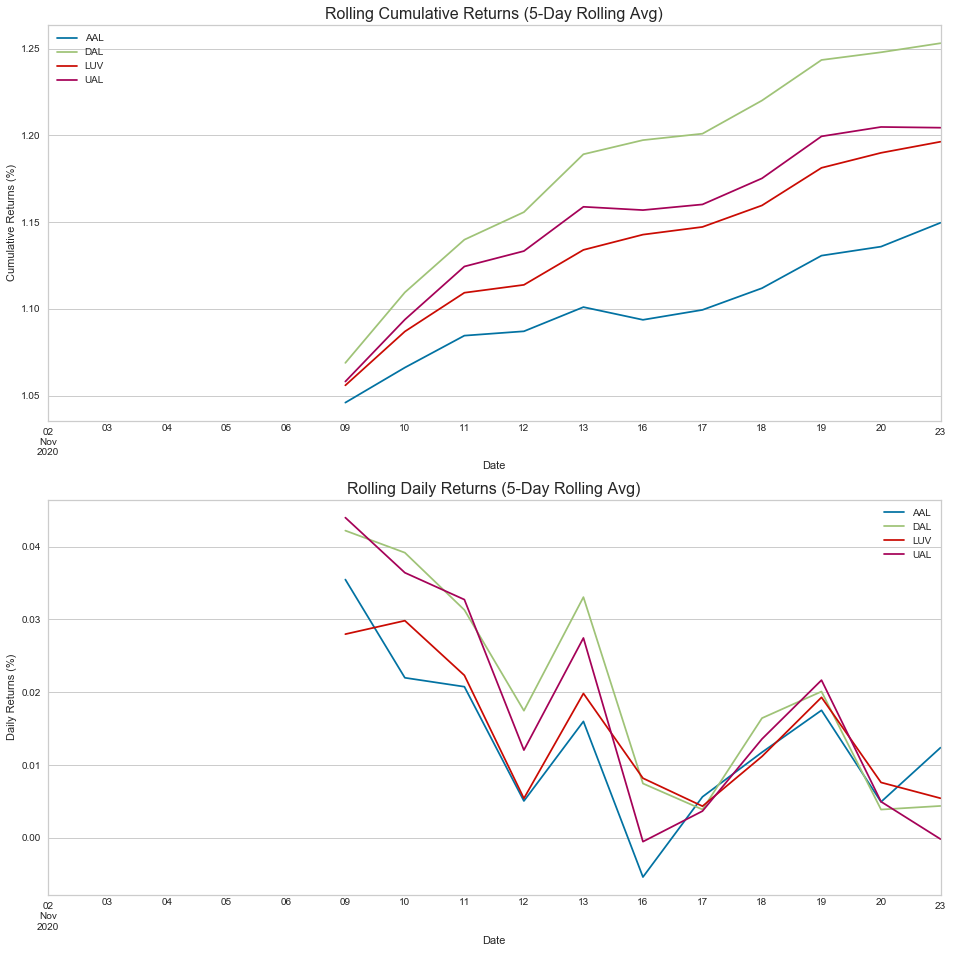

In [30]:
# create figure and axes
fig, ax = plt.subplots(2,1,figsize=(16,16))

# Common ETF's we will use to compare against tweet sentiment grouped by financial sector
Stocks = ['AAL', 'DAL', 'LUV', 'UAL']

# for each stock, calculate returns, cumulative returns and then plot 5 day rolling avg of cumulative returns
for stock in Stocks:
    locals()[stock]['returns'] = locals()[stock]['Close'].pct_change(1)
    locals()[stock]['Cumulative Return'] = (1 + locals()[stock]['returns']).cumprod()
    locals()[stock]['Cumulative Return'].rolling(5).mean().plot(label= stock, ax = ax[0])
    locals()[stock]['returns'].rolling(5).mean().plot(label= stock, ax = ax[1])

ax[0].set_title('Rolling Cumulative Returns (5-Day Rolling Avg)', size = 16)
ax[0].set_ylabel('Cumulative Returns (%)')
ax[0].legend()

ax[1].set_title('Rolling Daily Returns (5-Day Rolling Avg)', size = 16)
ax[1].set_ylabel('Daily Returns (%)')
ax[1].legend()
plt.show();

# Note this could have been done for each company individually using: 
# LUV['returns'] = LUV['Close'].pct_change(1)
# LUV['Cumulative Return'] = (1 + LUV['returns']).cumprod()
# LUV['Cumulative Return'].rolling(5).mean().plot(label='Southwest',figsize=(16,8),title='Rolling Returns (5-Day Rolling Avg)')


### Results

> We do not have enough sentiment data to make any claims. However, given the data we have thus far, we have seen that Twitter users are most likely to complain about American Airlines. Over this same time-frame, the 5-day moving average of AAL returns is also lagging compared to other US airlines. We cannot say these two events relate because of a lack of data. Ideally, we would have years of sentiment data - then we could take the moving average of both sentiment and stock prices to eliminate the noise associated with social media and markets.

## 3. Broad Market Sentiment Analysis

### Extracting Data

In [31]:
# read the data from csv files
StockDF = pd.read_csv('TwitterStockData.csv')
SentimentDF = pd.read_csv('tweet_sentiment.csv')

# declare start and end date for financial data
start = datetime.datetime(2018,7,17)
end = datetime.datetime(2018,10,25)

# read S&P500 data for declared dates
SPY500 = web.DataReader('SPY', 'yahoo', start, end)
BTC = web.DataReader('BTC-USD', 'yahoo', start, end)

StockDF.head()

,text,timestamp,source,symbols,company_names,url,verified
0,VIDEO: “I was in my office. I was minding my o...,Wed Jul 18 21:33:26 +0000 2018,GoldmanSachs,GS,The Goldman Sachs,https://twitter.com/i/web/status/1019696670777...,TRUE
1,The price of lumber $LB_F is down 22% since hi...,Wed Jul 18 22:22:47 +0000 2018,StockTwits,M,Macy's,https://twitter.com/i/web/status/1019709091038...,TRUE
2,Who says the American Dream is dead? https://t...,Wed Jul 18 22:32:01 +0000 2018,TheStreet,AIG,American,https://buff.ly/2L3kmc4,TRUE
3,Barry Silbert is extremely optimistic on bitco...,Wed Jul 18 22:52:52 +0000 2018,MarketWatch,BTC,Bitcoin,https://twitter.com/i/web/status/1019716662587...,TRUE
4,How satellites avoid attacks and space junk wh...,Wed Jul 18 23:00:01 +0000 2018,Forbes,ORCL,Oracle,http://on.forbes.com/6013DqDDU,TRUE


In [32]:
SentimentDF.head()

,cleaned_tweets,sentiment
0,video offic mind busi david solomon tell gs in...,0
1,price lumber lb f sinc hit ytd high maci turna...,0
2,say american dream dead,-1
3,barri silbert extrem optimist bitcoin predict ...,1
4,satellit avoid attack space junk circl earth paid,-1


In [33]:
SPY500.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-07-17,280.910004,278.410004,278.470001,280.470001,52315500.0,268.572174
2018-07-18,281.179993,280.059998,280.559998,281.059998,44593500.0,269.137207
2018-07-19,280.739990,279.459991,280.309998,280.000000,61412100.0,268.122101
2018-07-20,280.480011,279.500000,279.769989,279.679993,82337700.0,267.815704
2018-07-23,280.429993,279.059998,279.450012,280.200012,47047600.0,268.313629


#### Tidying Data

> The data we have used here was conveniently formatted in a way that did not require much altering. The data from Kaggle contained two separate CSV files. One for tweet information, and another for sentiment scores for cleaned tweets (a cleaned tweet omits unimportant words). Since sentiment scores are different from tweet information, this is exactly how we hoped the tables would be formatted. We can combine the two tables based on the indexes, as we do below:

In [34]:
# merge the two data frames (tweet info and tweet sentiment) - inner join based on index
StockSentimentDF = StockDF.merge(SentimentDF, how='inner', left_index = True, right_index=True)

#### Scrapping Additional Data 
>We wanted to use additional data so we scrapped data using the Python Yahoo! Finance library. This allows us to add useful info such as stock price movements (in the days following the tweet), tweet date as a datetime object, and the stock's sector. Using Yahoo Finance to scrape is extremely time-intensive, so we ran it on small subsets of our data and appended the results to a CSV file stored in local storage. This way we can read a CSV file in local storage instead of repeatedly scraping. To demonstrate the web scraping, we left the following example using the first ten entities:


In [35]:
StockSentimentDF = StockSentimentDF.head(10)

def getStockData(symbol, date):
        if not "-" in symbol:
            t = yf.download(symbol, start=date, end=date + datetime.timedelta(days=1))
            if t.size > 0:
                perc_change = (t["Open"].iloc[0] - t["Close"].iloc[0] ) / t["Open"].iloc[0]  * 100
                return perc_change
            return None
        else:
            return None
        
def getSector(symbol):
    try:
        ticker = yf.Ticker(symbol)
        c = ticker.info['sector']
        return c
    except:
        return None
    
def tweetDate(timestamp):
    t = datetime.datetime.strptime(timestamp, "%a %b %d %H:%M:%S +0000 %Y")
    return t.date()

StockSentimentDF["date"] = StockSentimentDF.apply(lambda row: tweetDate(row["timestamp"]), axis = 1)

StockSentimentDF["perc_change"] = StockSentimentDF.apply(lambda row: getStockData(row["symbols"], row["date"]), axis = 1)
StockSentimentDF["NextDay_perc_change"] = StockSentimentDF.apply(lambda row: getStockData(row["symbols"], row["date"] + datetime.timedelta(days=1)), axis = 1)
StockSentimentDF["sector"] = StockSentimentDF.apply(lambda row: getSector(row["symbols"]), axis = 1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BTC: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- HRS: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BTC: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*****

>Note: Many of the observations will return 'failed to download' because most of our data is from 2018 and many ticker symbols have changed or been delisted.

<br>

Our data table now appears in the following format:

In [36]:
StockSentimentDF.head()

,text,timestamp,source,symbols,company_names,url,verified,cleaned_tweets,sentiment,date,perc_change,NextDay_perc_change,sector
0,VIDEO: “I was in my office. I was minding my o...,Wed Jul 18 21:33:26 +0000 2018,GoldmanSachs,GS,The Goldman Sachs,https://twitter.com/i/web/status/1019696670777...,TRUE,video offic mind busi david solomon tell gs in...,0,2018-07-18,0.473440,0.640386,Financial Services
1,The price of lumber $LB_F is down 22% since hi...,Wed Jul 18 22:22:47 +0000 2018,StockTwits,M,Macy's,https://twitter.com/i/web/status/1019709091038...,TRUE,price lumber lb f sinc hit ytd high maci turna...,0,2018-07-18,-1.425888,-3.096052,Consumer Cyclical
2,Who says the American Dream is dead? https://t...,Wed Jul 18 22:32:01 +0000 2018,TheStreet,AIG,American,https://buff.ly/2L3kmc4,TRUE,say american dream dead,-1,2018-07-18,-0.859863,1.912574,Financial Services
3,Barry Silbert is extremely optimistic on bitco...,Wed Jul 18 22:52:52 +0000 2018,MarketWatch,BTC,Bitcoin,https://twitter.com/i/web/status/1019716662587...,TRUE,barri silbert extrem optimist bitcoin predict ...,1,2018-07-18,NaN,NaN,None
4,How satellites avoid attacks and space junk wh...,Wed Jul 18 23:00:01 +0000 2018,Forbes,ORCL,Oracle,http://on.forbes.com/6013DqDDU,TRUE,satellit avoid attack space junk circl earth paid,-1,2018-07-18,0.307443,-0.082639,Technology


In [37]:
# read the data we have already scraped and saved locally
StockSentimentDF = pd.read_csv('WebScrapedStockData.csv')
StockSentimentDF['date'] = pd.to_datetime(StockSentimentDF['date']) #change date column to datetime object

### Exploratory Data Analysis

#### Stock Sectors
> First, we looked at the sector of stocks mentioned in our Twitter data.  Our distribution contains several different sectors, which means that users on Twitter are interested in a very diverse set of stocks.

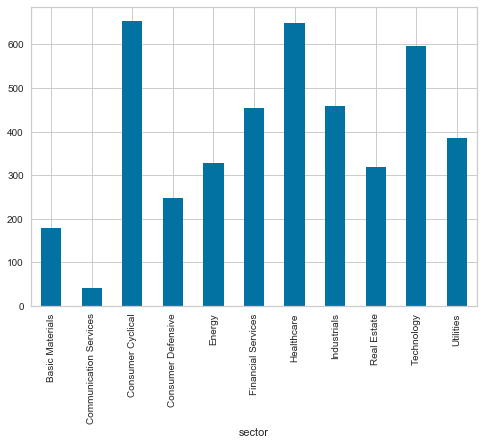

In [38]:
# count how many instances of each sector
Sectors = StockSentimentDF.groupby(['sector']).count()
Sectors["text"].plot.bar()

#### Gauging Sector Sentiment
>We can attempt to gauge if tweet sentiment grouped by sector helps us determine trends in various sectors. The ETF's we will use to measure performance are the following:

>- Energy: XLE
>- Materials: XLB
>- Industrials: XLI
>- Consumer Discretionary: XLY
>- Consumer Staples: XLP
>- Health Care: XLV
>- Financials: XLF
>- Information Technology: SMH
>- Telecommunication Services: XTL
>- Utilities: XLU
.- Real Estate: IYR 

First, we determine what our data says about various sectors by summing the net sentiment analysis for each sector:

sector
Basic Materials            73
Communication Services      8
Consumer Cyclical         141
Consumer Defensive         58
Energy                     64
Financial Services         85
Healthcare                115
Industrials               102
Real Estate                63
Technology                110
Utilities                  37
Name: sentiment, dtype: int64


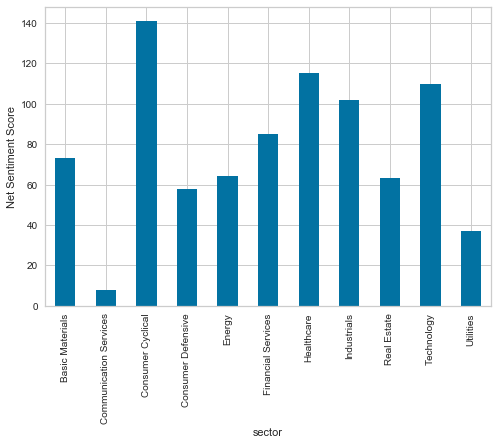

In [39]:
# bar plot of the net sentiment value for each sector
StockSentimentDF.groupby(['sector']).sentiment.sum().plot.bar();
plt.ylabel('Net Sentiment Score')

# print total sentiment score table - Notice they are all positive
print(StockSentimentDF.groupby(['sector']).sentiment.sum())

Note: Notice how all the sectors have a net positive sentiment score. This might mean a couple of things:
>1. The market is healthy across most sectors at this time (possibly some healthier than others)
>2. The algorithm used to calculate sentiment is not accurate (biased in thinking tweets are positive)
>3. People generally tweet more about positive things than negative things

> We believe the sentiment scores are likely biased. Unfortunately, we do not know what methods the Kaggle user used to calculate sentiment for these tweets. By hand-checking a subset of their data, we found roughly 50% of instances to be correctly labeled. It is important to note that because this is a ternary classification model, 50% is still quite a bit better than random guessing.

We know from the previous section that the distribution of tweets by sector is not evenly distributed (i.e. there are more than 600 tweets about healthcare and consumer cyclical companies and less than 100 tweets regarding communication services). Thus, it is probably better to look at the mean sentiment analysis by each sector:

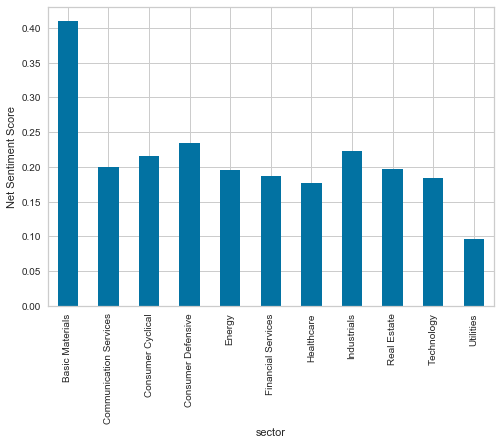

In [40]:
StockSentimentDF.groupby(['sector']).sentiment.mean().plot.bar();
plt.ylabel('Net Sentiment Score')
plt.show();

Now we record info on the specified ETF's that relate to each sector:

In [41]:
# Common ETF's we will use to compare against tweet sentiment grouped by financial sector
ETFs = ['XLE', 'XLB', 'XLI', 'XLY', 'XLP', 'XLV', 'XLF', 'SMH', 'XTL', 'XLU', 'IYR']

# for each etf, grab the data for the desired dates
for etf in ETFs:
    locals()[etf] = web.DataReader(etf, 'yahoo', start, end) # save price information to local variable with name of ETF

#### Comparing Sector ETF Returns
> We saw in the previous section that the Consumer Cyclical and Industrial sectors seem to have a positive sentiment on Twitter. Communications and Utilities appear to be lagging in terms of net tweet sentiment (more neutral). We first calculate the returns for these sectors using the ETF's described above, and then we compare the distribution of these sectors returns (daily percent change) using a histogram and a kernel density plot.


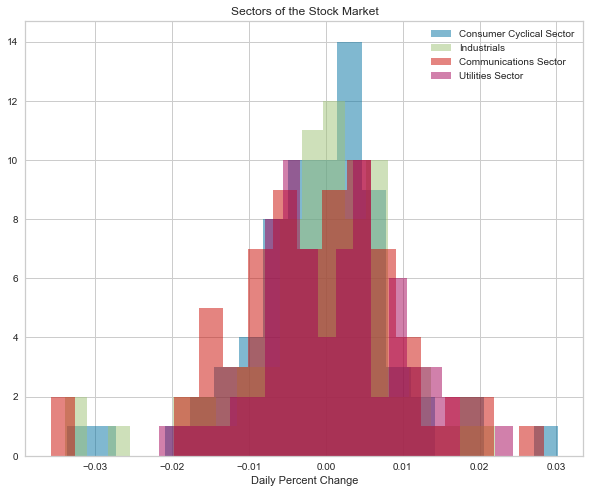

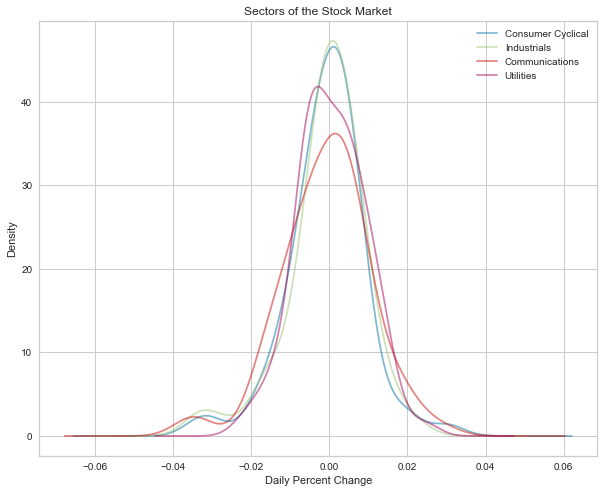

In [42]:
# Calculate returns for positive sentiment sectors
XLY['Returns'] = (XLY['Close'] / XLY['Close'].shift(1)) - 1 # Consumer Cyclical
XLI['Returns'] = (XLI['Close'] / XLI['Close'].shift(1)) - 1 # Industrials

# Calculate returns for the more neutral sentiment sectors
XTL['Returns'] = (XTL['Close'] / XTL['Close'].shift(1)) - 1 # Communications
XLU['Returns'] = (XLU['Close'] / XLU['Close'].shift(1)) - 1 # Utilities

# alternative method: XLU['Returns'] = XLU['Close'].pct_change(1)

XLY['Returns'].hist(bins=20, label = 'Consumer Cyclical Sector', figsize = (10,8), alpha = 0.5)
XLI['Returns'].hist(bins=20, label = 'Industrials', figsize = (10,8), alpha = 0.5)
XTL['Returns'].hist(bins=20, label = 'Communications Sector', figsize = (10,8), alpha = 0.5)
XLU['Returns'].hist(bins=20, label = 'Utilities Sector', figsize = (10,8), alpha = 0.5)
plt.xlabel('Daily Percent Change')
plt.title('Sectors of the Stock Market')
plt.legend()
plt.show();

# simliar method for kernal density plot
XLY['Returns'].plot(kind = 'kde', label = 'Consumer Cyclical', figsize = (10,8), alpha = 0.5)
XLI['Returns'].plot(kind = 'kde', label = 'Industrials', figsize = (10,8), alpha = 0.5)
XTL['Returns'].plot(kind = 'kde', label = 'Communications', figsize = (10,8), alpha = 0.5)
XLU['Returns'].plot(kind = 'kde', label = 'Utilities', figsize = (10,8), alpha = 0.5)
plt.xlabel('Daily Percent Change')
plt.title('Sectors of the Stock Market')
plt.legend()
plt.show();

This shows us that the Consumer Cyclical and Industrial ETF's had less volatility. We can also see that Utilities did not perform well over this period because the peak density is a negative percent change. The Communications ETF was more volatile than the others over this period (we can tell because it is a wider distribution).

#### Number of stock tweets per day
> Next, we were interested in the number of tweets any given stock gets in one day.  Our set is rather limited, and the most popular symbol-date pairings are shown below.  

In [43]:
b = StockSentimentDF.groupby(['symbols', 'date']).count()
b = b.sort_values("text", ascending = False).head() # top 5 most commonly tweeted stocks on any given day
selection = b['text']
print(selection) # print the 5 most popular symbol-date pairings

symbols  date      
MHK      2018-07-11    33
IP       2018-07-10    33
ABC      2018-07-12    30
DLPH     2018-07-09    29
NBL      2018-07-12    29
Name: text, dtype: int64


### Determining Correlation

#### Plotting Price Percent Change vs. Average Sentiment

> Here, we take the average sentiment from Twitter regarding a particular stock on a particular date, and plot it against the percent change on that day.  We expect to see a positive correlation between the two because if a stock performs well on a given day, we expect general optimism throughout Tweets on that day. 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Correlation:  -0.007066127090598155


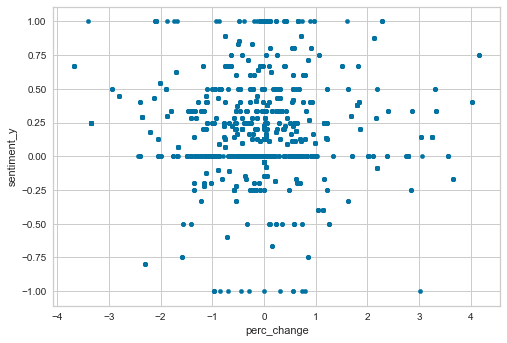

In [44]:
m = StockSentimentDF.groupby(['symbols', 'date']).mean()
t = StockSentimentDF.merge(m, on=["symbols", "perc_change"])
t.plot.scatter(x="perc_change", y="sentiment_y")
print("Correlation: ", t["perc_change"].corr(t["sentiment_y"]))

#### Plotting Next-Day Price Percent Change vs. Average Sentiment
> This is similar to the plot above.  However, instead of looking at the price percent change of the day of the tweet, we are now looking at the price percent change of the next day.  In essence, a positive correlation means that optimistic tweets might have optimistic effects on a stock on the following day.  

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Correlation:  0.0391721642623727


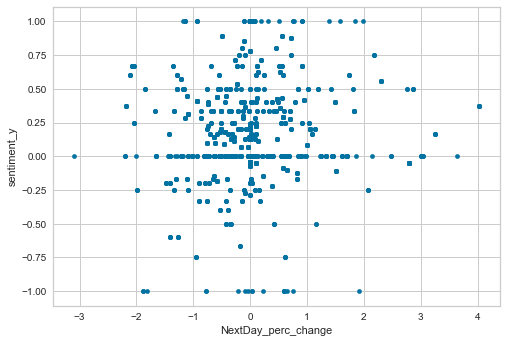

In [45]:
m = StockSentimentDF.groupby(['symbols', 'date']).mean()
t = StockSentimentDF.merge(m, on=["symbols", "NextDay_perc_change"])
t.plot.scatter(x="NextDay_perc_change", y="sentiment_y")
print("Correlation: ", t["NextDay_perc_change"].corr(t["sentiment_y"]))

### Overall Market Sentiment vs Bitcoin Sentiment

>We also wanted to check to see if Twitter sentiment could gauge whether Bitcoin or the overall market (we'll use the S&P500 to measure this) is more likely to rise. We first create two bar plots to compare Twitter's bitcoin sentiment and Twitter's market sentiment (Non-cryptocurrencies).

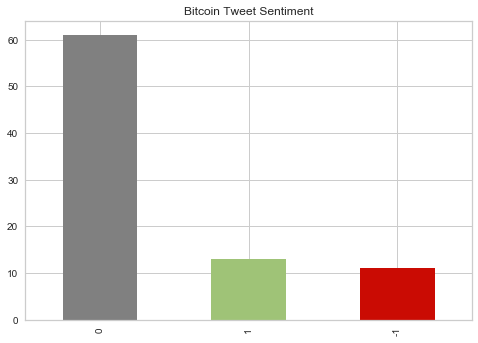

In [46]:
# read the data from csv files
StockDF = pd.read_csv('TwitterStockData.csv')
SentimentDF = pd.read_csv('tweet_sentiment.csv')
                          
# merge the two data frames (tweet info and tweet sentiment) - inner join based on index
StockSentimentDF = StockDF.merge(SentimentDF, how='inner', left_index = True, right_index=True)

# create a bar graph displaying the number of neutral, positive and negative BTC tweets 
colors = ['grey','g','r']
StockSentimentDF[StockSentimentDF.symbols == 'BTC'].sentiment.value_counts().plot.bar(color = colors, title = "Bitcoin Tweet Sentiment");

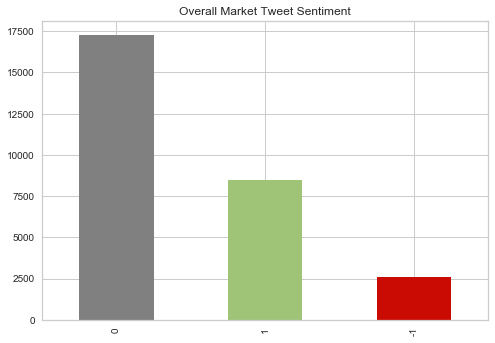

In [47]:
# create a bar graph displaying the number of neutral, positive and negative non-BTC tweets (Overall Market)
StockSentimentDF[StockSentimentDF.symbols != 'BTC'].sentiment.value_counts().plot.bar(color = colors, title = "Overall Market Tweet Sentiment");

>The first graph would suggest that Bitcoin sentiment is somewhat neutral (there is no real consensus), but the second graph suggests Twitter has a more optimistic view of the overall market.
<br>

Let's see how Bitcoin and the overall market did during the time our data was collected:

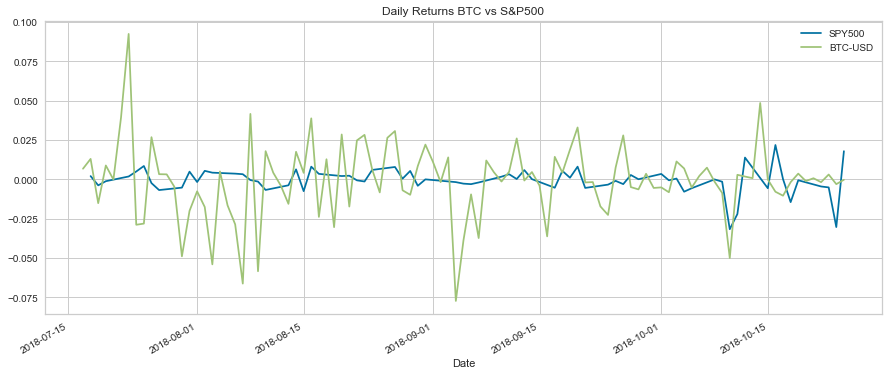

In [48]:
# calculate daily percent change in new column 'returns'
SPY500['returns'] = SPY500['Close'].pct_change(1)
BTC['returns'] = BTC['Close'].pct_change(1)

# plot the daily returns for BTC and SPY500
SPY500['returns'].plot(kind = 'line', title = "Daily Returns BTC vs S&P500", label = 'SPY500', figsize = (15,6))
BTC['returns'].plot(kind = 'line', title = "Daily Returns BTC vs S&P500", label = 'BTC-USD', figsize = (15,6))
plt.legend()
plt.show()

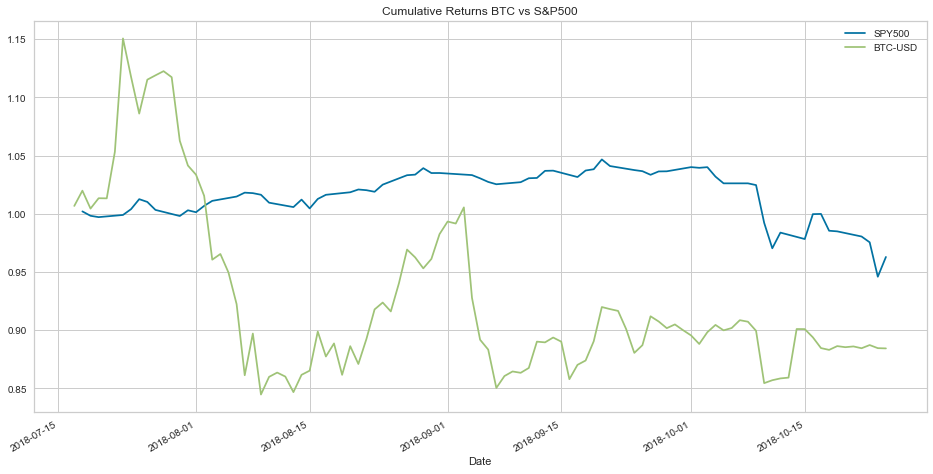

In [49]:
# calculate cumulative returns in a new column ''daily_cumulative_return'
SPY500['daily_cumulative_return'] = ( 1 + SPY500['returns'] ).cumprod()
BTC['daily_cumulative_return'] = ( 1 + BTC['returns'] ).cumprod()

# plot the cumulative returns for BTC and SPY500
SPY500['daily_cumulative_return'].plot(label='SPY500',figsize= (16,8))
BTC['daily_cumulative_return'].plot(label = 'BTC-USD', title = "Cumulative Returns BTC vs S&P500")
plt.legend();
plt.show()


>#### Results
>While the overall market (the SPY500) did outperform Bitcoin during the timeframe our data was collected, neither performed particularly well. The first graph shows us that bitcoin is much more volatile over this period and the second graph shows us that both investments would result in a net loss over this time period.

## Final Thoughts 

>There are a lot of factors when it comes to pricing equities and nearly an infinite number of reasons someone might decide to tweet something. Due to this, there is a significant amount of noise in both the stock market and sentiment analysis data - making it extremely difficult to determine if there is any correlation between the two. 

>We worry about the accuracy of the sentiment analysis data in section 3 (broad markets) because we are not sure how this data was classified. It seems that this Kaggle user may have trained their model using general tweets and tried to apply this model to financial tweets. Sentiment analysis is a tricky thing to do with a high degree of accuracy, and we have learned (the hard way) that there is a lot to consider and there are no hard and fast rules to this process. Social media has additional challenges because the text is not written in a consistent style (i.e. slang, sarcasm, misspellings, abbreviations, etc.). We have seen that it is critical to restrict the domain when possible to increase the accuracy of NLP learning models. 

>Training on all financial tweets is likely too broad to make any meaningful conclusions. Training on one company (aapl in our case) does not let us compare results with other competitors. The most interesting subset, by far, is the airline data because the customer experience is one of the few things that distinguishes various airlines. With our very limited data, we have seen that Southwest, Delta, and United have better sentiment than American Airlines. We hypothesize that these trends in sentiment may correlate with stock price movement over long periods.

>This Project has left us with more questions than answers; however, we believe we have laid the groundwork to piece together the answers in the future. Obviously, to draw any significant conclusions regarding the correlation between stocks and sentiment we need heaps of sentiment data. Now that we understand some of the intricacies of scraping and training classification models, we can continue to scrape data - continuing our pursuit to find more concrete answers.

### Where to Next?

>At the onset of this project, we only intended to use financial tweets. Due to limitations in the data, we expanded our research to include consumers' tweets. One of our questions was whether we should be looking at sentiment as a leading or lagging indicator of stock prices. 

>We hypothesize this may depend on whether we analyze consumer or verified financial accounts. We believe financial Twitter accounts may indicate previous market movements, but consumer data may be more indicative of future price movements. We imagine a scenario where consumers fall in love or out of love with a product or service before markets can price this shift in consumer demand accordingly. We think this question warrants further investigation.